# Computer Vision Coursework Submission (INM460)

**Student name, ID and cohort:** Vinita Kumari Jhakra (200056789) - PG


# Notebook Setup
In this section you should include all the code cells required to test your coursework submission. Specifically:

### Mount Google Drive

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [48]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_PG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_PG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'My_Computer_vision/CV_Coursework/CW_Folder_PG_template/CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Models', 'Video', 'CW_Dataset', 'Code', 'Report template.docx', 'test_functions_v3.ipynb']


### Load packages

In the next cell you should load all the packages required to test your functions.

In [133]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
import joblib
from skimage import io, color, img_as_float, img_as_ubyte
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn import svm, metrics
from sklearn.utils import shuffle
from collections import Counter
from skimage.transform import resize
import random
from skimage.io import imread
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.pyplot as plt
from joblib import load
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch
import sklearn
from matplotlib import patches
import torch
import torch.nn as nn
import torch.nn.functional as F
%load_ext autoreload
%autoreload 2
import sys
CODE_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Code')
sys.path.append(CODE_PATH)
# loading required functions from module image_test_functions
from image_test_functions import FileNameList_test,Fetch_images_test,Fetch_text_data_test, ResizeAndHOGTransformation,load_cnn_mobileNetV2_model, load_cnn_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load models

In the next cell you should load all your trained models for easier testing of your functions. Avoid to load them within `MaskDetection` and `MaskDetectionVideo` to avoid having to reload them each time.

In [50]:
# to specify 'CPU' device which is used to perform all the operations
device = torch.device('cpu')

In [71]:
#load models

#this will load MLP model (Trained on HOG feature descriptors)
mlp_model = load((os.path.join(GOOGLE_DRIVE_PATH, 'Models','MLP_hog_final')))
#this will load SVM model (Trained on HOG feature descriptors)
svm_model = load((os.path.join(GOOGLE_DRIVE_PATH, 'Models','svm_model_hog')))
#this will load cnn model
cnn_model = load_cnn_model(os.path.join(GOOGLE_DRIVE_PATH,'Models','cnn_best_model_final.pth'))
#this will load cnn model trained by transfer learning from MobileNetV2
cnn_mobileNetV2_model = load_cnn_mobileNetV2_model(os.path.join(GOOGLE_DRIVE_PATH,'Models','cnn_MobileNet_final.pth'))


# Test MaskDetection

This section should allow a quick test of the `MaskDetection` function. First, add cells with the code needed to load the necessary subroutines to make `MaskDetection` work.

In [72]:
#Code for mask detection

#Transformation required for trained model CNN MoibleNetV2
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
#Transformation required for trained model CNN
transform_cnn = transforms.Compose([
    transforms.ToPILImage(),#conversion to PIL images
    transforms.Resize((128, 128)), #resizing images
    transforms.ToTensor(),#conversion to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) #normalisation
])
# MaskDetection function to visualise the predictions made by input model
# Paramter path_to_testset is google drive path for test dataset
# Paramter model_type is to input the selected model
def MaskDetection(path_to_testset, model):
    test_images_filenames, test_labels_filenames = FileNameList_test(path_to_testset, 'CW_Dataset/test/images', '.jpeg')
    test_images_data = Fetch_images_test(path_to_testset, 'CW_Dataset/test/images', test_images_filenames)
    test_label_data = Fetch_text_data_test(path_to_testset, 'CW_Dataset/test/labels', test_labels_filenames)


    if model == cnn_mobileNetV2_model:
        # CNN model
        with torch.no_grad():
            model.eval()
            y_pred = []
            y_label_test = []
            for i in range(len(test_images_data)):
                images = transform(test_images_data[i]).unsqueeze(0)
                labels = int(test_label_data[i])
                images = images.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_label_test.append(int(test_label_data[i]))
    elif ((model ==svm_model) or (model== mlp_model)):
        # SVM or MLP model
        test_images_data, y_label_test, HOG_descriptors_test, HOG_images_test = ResizeAndHOGTransformation(test_images_data, test_label_data, 128, 128)
        y_pred = model.predict(HOG_descriptors_test)

    elif model == cnn_model:
      with torch.no_grad():
            model.eval()
            y_pred = []
            y_label_test = []
            for i in range(len(test_images_data)):
                images = transform_cnn(test_images_data[i]).unsqueeze(0)
                labels = int(test_label_data[i])
                images = images.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_label_test.append(int(test_label_data[i]))
    else:
      print('Incorrect model type')
      return





    fig, axes = plt.subplots(1, 4, sharex=True, sharey=True)
    ax = axes.ravel()
    dict = {0: 'No Mask', 1: 'Mask', 2: 'Incorrect Mask'}
    for i in range(4):
        ax[i].imshow(test_images_data[i])

        ax[i].set_title(f'Label: {dict[y_label_test[i]]} \n Prediction: {dict[y_pred[i]]}', fontsize=8)
        ax[i].set_axis_off()
    fig.tight_layout()
    plt.show()

Then, make a call to the `MaskDetection` function to see what results it produces. You must also indicate the syntax needed to test your different models.

In [ ]:
# Syntax for the next function is the following:
#
# MaskDetection(path_to_testset, model_type)
#
# where model_type can be one of
#   - hog-svm
#   - hog-mlp
#   - cnn

# path_to_testset = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/test')
# MaskDetection(path_to_testset, 'hog-svm')

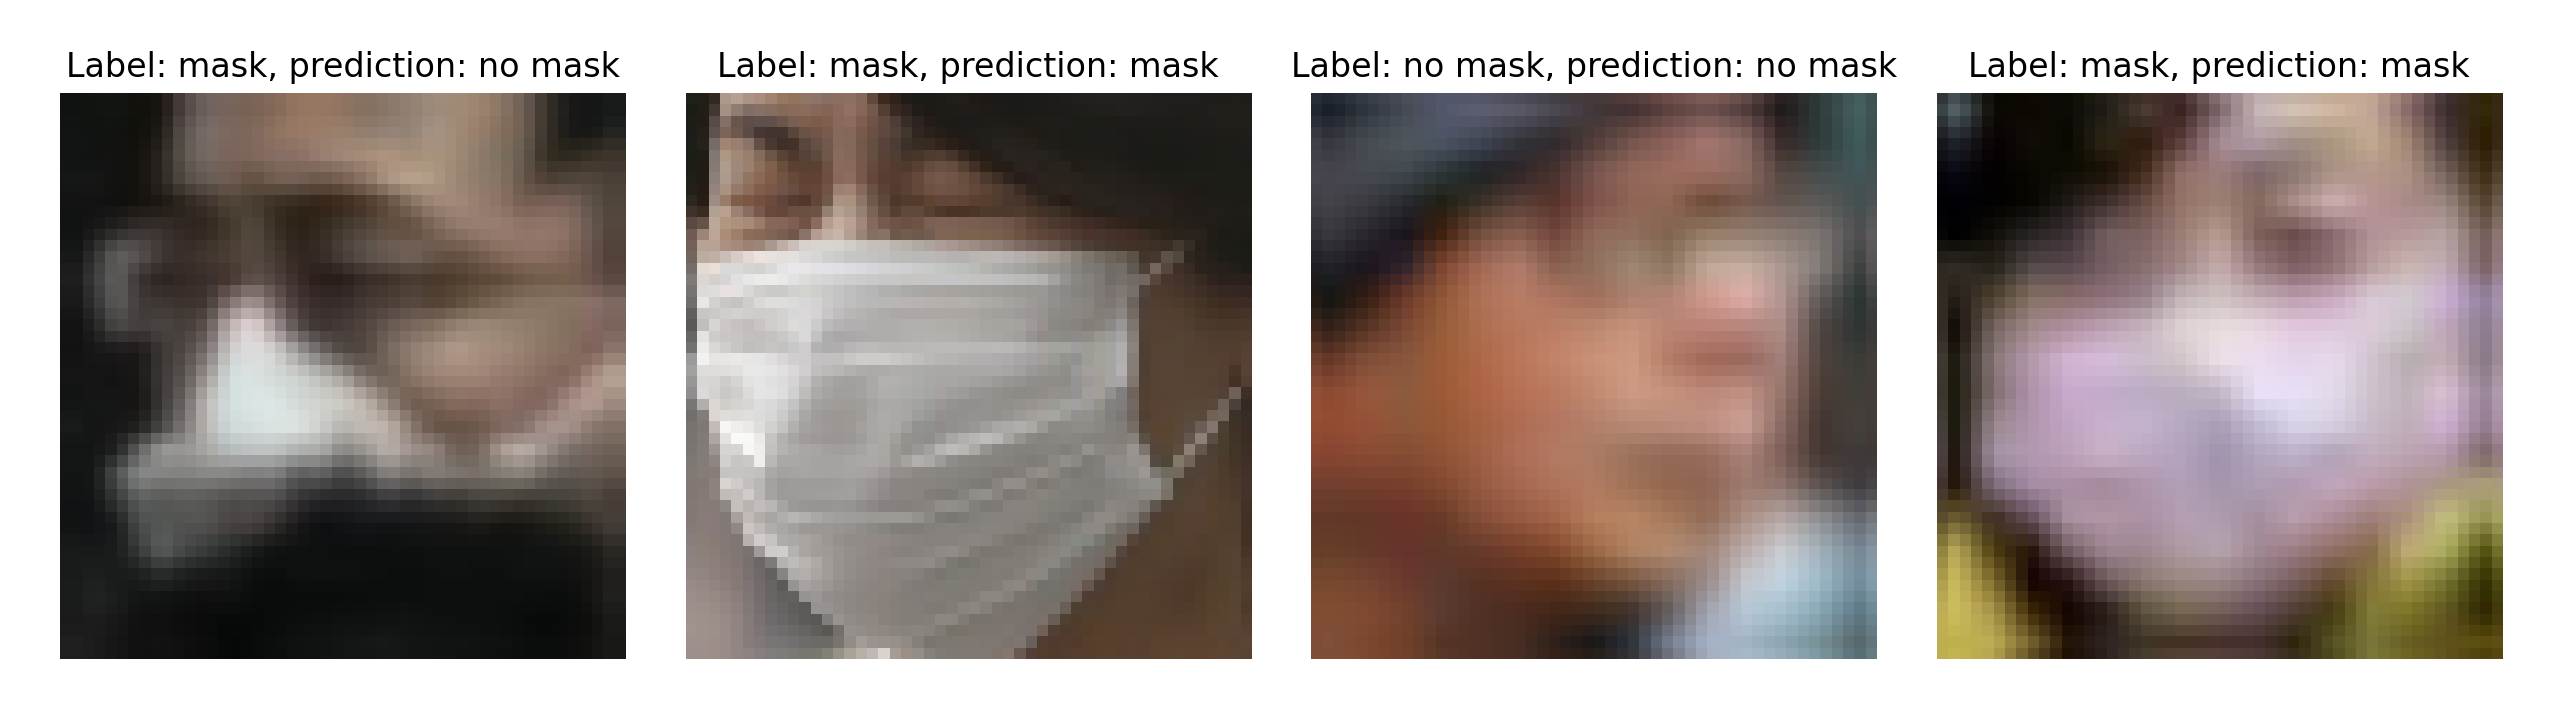

**Test Mask Detection on images:**
Uncomment to check predictions on different models

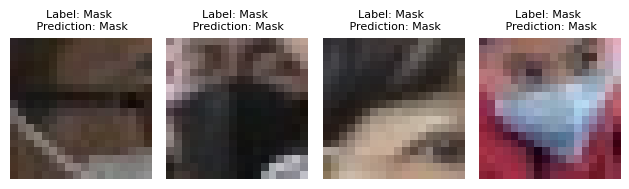

In [132]:
# Please uncomment the respective line to the model you would like to test the results for.
# MaskDetection(GOOGLE_DRIVE_PATH,cnn_model) # Mask detection prediction using CNN model
# MaskDetection(GOOGLE_DRIVE_PATH,mlp_model) # Mask detection prediction using MLP model
MaskDetection(GOOGLE_DRIVE_PATH,svm_model) # Mask detection prediction using SVM model
# MaskDetection(GOOGLE_DRIVE_PATH,cnn_mobileNetV2_model) # Mask detection prediction using CNN MobileV2 model

# Test MaskDetectionVideo

This section should allow a quick test of the `MaskDetectionVideo` function. First, add cells with the code needed to load the necessary subroutines to make `MaskDetectionVideo` work.

In [109]:
!pip install facenet-pytorch

In [110]:
from facenet_pytorch import MTCNN
from matplotlib import patches
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt

In [116]:
from google.colab import drive
import shutil
import os
video_pathMask = os.path.join(GOOGLE_DRIVE_PATH, 'Video/mask3_video.mp4')

# set the path where video needs to be saved in colab with the name
colab_path = '/content/mask_video.mp4'

#checking if file exist in the video path provided
if os.path.exists(video_pathMask):
    # Copy the video file to Colab workspace
    shutil.copy(video_pathMask, colab_path)
    print("Video successfully copied to the colab workbook.")
else:
    print("Video not available at the given source path")

Video successfully copied to the workspace.


In [126]:
mtcnn= MTCNN()
def load_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_Count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_Width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_Height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video = np.empty((frame_Count, frame_Height, frame_Width, 3), np.dtype('uint8'))
    f_count = 0
    ret = True
    while f_count < frame_Count and ret:
        ret, video[f_count] = cap.read()
        video[f_count] = cv2.cvtColor(video[f_count], cv2.COLOR_BGR2RGB)
        f_count += 1
    cap.release()
    return video

def update(frame):
    ax.clear()  # Clear the axis for each frame
    img = video[frame]
    faces_MTCNN, _ = mtcnn.detect(img, landmarks=False)
    if faces_MTCNN is not None:
        for face in faces_MTCNN:
            x1, y1, x2, y2 = face.astype(int)
            if x1 >= 0 and y1 >= 0 and x2 < img.shape[1] and y2 < img.shape[0]:
                face_image = img[y1:y2, x1:x2]
                with torch.no_grad():
                    predictions = []
                    image = face_image
                    image = transform(image).unsqueeze(0)
                    repeated_image_tensor = image.repeat(32, 1, 1, 1)
                    output = cnn_mobileNetV2_model(image)
                    _, predicted = torch.max(output.data, 1)
                    predictions.extend(predicted.cpu().numpy())
                ax.imshow(img)
                ax.set_axis_off()
                if predictions[0] == 0:
                    color = 'red'
                    text = 'No Mask'
                elif predictions[0] == 1:
                    color = 'green'
                    text = 'Mask'
                else:
                    color = 'blue'
                    text = 'Incorrect Mask'
                ax.add_patch(patches.Rectangle(xy=(face[0], face[1]), width=face[2] - face[0], height=face[3] - face[1], fill=False, color=color, linewidth=2, label='test'))
                ax.text(face[0]+18, face[1]-10, text, fontsize=12, color=color, ha='center', va='center')

    return ax

def MaskDetectionVideo(path):
    global video, fig, ax
    video = load_video(path)
    fig, ax = plt.subplots()
    # ani = animation.FuncAnimation(fig, update, frames=len(video), interval=50)
    ani = animation.FuncAnimation(fig, update, frames=150, interval=50)
    plt.close()
    return HTML(ani.to_html5_video())

In [127]:
MaskDetectionVideo(colab_path)

In [ ]:
# MaskDetectionVideo(colab_path)


Output hidden; open in https://colab.research.google.com to view.